# Génération de mélodies allemandes avec un LSTM (dataset "deutsch")

In [1]:
import os
import music21 as m21
import json
from datetime import datetime
from preprocessing import *
from training import *

### Paramètres

In [2]:
DATASET_PATH = "../data/deutsch/original_songs"
SAVE_DIR_ENCODED_SONGS = "../data/deutsch/encoded_songs"

SEQUENCE_LENGTH = 64
FILE_DATASET_PATH = "../data/deutsch/file_dataset"
MAPPINGS_PATH = "../data/deutsch/mapping.json"

NUM_UNITS = [256]
LOSS = "sparse_categorical_crossentropy"
LEARNING_RATE = 0.001
EPOCHS = 10
BATCH_SIZE = 64

MODEL_PATH = "../data/deutsch/model_RNN_LSTM.keras"

MAPPING_PATH = "../data/deutsch/mapping.json"
SAVE_GENERATED_MELODIES_DIR = "../generated_melodies/RNN-LSTM/deutsch"
seed = "55"

## Préparation des données

In [3]:
print("loading data...")
songs = load_songs(DATASET_PATH, 10000)
print(len(songs),"songs loaded")

loading data...
1700 songs loaded


Enlever durées non acceptables (notes plus courtes que double croche) et musiques vides

In [4]:
print("avant filtrage :", len(songs))
for song in songs:
    if not has_acceptable_durations(song, ACCEPTABLE_DURATIONS):
        songs.remove(song)
    if len(song.recurse().getElementsByClass(m21.note.Note)) == 0:
        songs.remove(song)
print("après filtrage :", len(songs))

avant filtrage : 1700
après filtrage : 1683


Transposer en do majeur

In [5]:
transposed_songs = []
for song in songs:
    transposed_songs.append(transpose(song))

Encoder les musiques en format fichier texte

In [6]:
encoded_songs = []
for song in transposed_songs:
    encoded_songs.append(encode_song(song))

sauvegarde dans un fichier texte

In [7]:
for i, encoded_song in enumerate(encoded_songs):
    save_path = os.path.join(SAVE_DIR_ENCODED_SONGS, str(i))
    with open(save_path, "w") as fp:
        fp.write(encoded_song)

Tout mettre dans un fichier

In [8]:
create_single_file_dataset(dataset_path = SAVE_DIR_ENCODED_SONGS, file_dataset_path=FILE_DATASET_PATH, sequence_length=SEQUENCE_LENGTH)

'55 _ 60 _ 60 _ 60 _ 62 _ 64 _ 62 _ 60 _ _ _ 64 _ 64 _ 64 _ 65 _ 67 _ _ 65 64 _ 60 _ 72 _ _ _ 72 71 69 _ 67 _ _ _ r _ 67 _ 69 _ 65 _ 62 _ 65 _ 67 _ 64 _ 60 _ 62 _ 64 _ 67 _ 65 _ 62 _ 60 _ _ _ r _ 67 _ 69 _ 65 _ 62 _ 65 _ 67 _ 64 _ 60 _ 62 _ 64 _ 67 _ 65 _ 62 _ 60 _ _ _ r _ / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / 55 _ 60 _ 60 _ 60 _ 64 _ 67 _ 64 _ 60 _ _ _ 64 _ 67 _ 67 _ 67 _ 72 _ 67 _ 64 _ 64 _ 67 _ _ _ 69 67 65 64 62 _ _ _ r _ 62 _ 60 _ 64 _ 67 _ 64 _ 62 _ 64 _ 65 _ 62 62 60 _ 64 _ 67 65 62 _ 60 _ _ _ r _ / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / 60 _ 64 _ 67 _ _ _ 67 _ 65 _ 64 _ 67 _ 72 _ _ _ 69 _ _ _ 69 _ 67 _ 65 _ _ _ 65 _ 67 _ 69 _ _ _ 69 _ _ _ 69 _ 71 _ 72 _ 74 _ 71 _ _ _ 67 _ _ _ 67 _ _ _ 67 _ _ _ 72 _ _ _ 72 _ _ _ 72 _ 74 _ 76 _ 72 _ 67 _ _ _ 69 _ 71 _ 72 _ _ _ / / / / / / / / / / / / / / / / / / / / / / / 

Mapping des symboles

In [9]:
songs=load(FILE_DATASET_PATH)
create_mapping(songs, MAPPINGS_PATH) 
mappings, OUTPUT_UNITS = load_json(MAPPINGS_PATH)
print(OUTPUT_UNITS)

38


## Entrainement

In [10]:
inputs, targets = generate_training_sequences(64, songs, mappings)

In [11]:
# build the model
model = build_model(OUTPUT_UNITS, NUM_UNITS, LOSS, LEARNING_RATE)

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, None, 38)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 256)            │       302,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 38)             │         9,766 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 311,846 (1.19 MB)

 Trainable params: 311,846 (1.19 MB)

 Non-trainable params: 0 (0.00 B)

In [12]:
# train the model

history = model.fit(inputs, targets, epochs=EPOCHS, batch_size=BATCH_SIZE)

Epoch 1/10
5660/5660 ━━━━━━━━━━━━━━━━━━━━ 322s 57ms/step - accuracy: 0.7712 - loss: 0.8240
Epoch 2/10
5660/5660 ━━━━━━━━━━━━━━━━━━━━ 293s 52ms/step - accuracy: 0.8091 - loss: 0.5917
Epoch 3/10
5660/5660 ━━━━━━━━━━━━━━━━━━━━ 327s 58ms/step - accuracy: 0.8258 - loss: 0.5393
Epoch 4/10
5660/5660 ━━━━━━━━━━━━━━━━━━━━ 297s 52ms/step - accuracy: 0.8348 - loss: 0.5116
Epoch 5/10
5660/5660 ━━━━━━━━━━━━━━━━━━━━ 378s 67ms/step - accuracy: 0.8414 - loss: 0.4889
Epoch 6/10
5660/5660 ━━━━━━━━━━━━━━━━━━━━ 367s 65ms/step - accuracy: 0.8467 - loss: 0.4689
Epoch 7/10
5660/5660 ━━━━━━━━━━━━━━━━━━━━ 330s 58ms/step - accuracy: 0.8516 - loss: 0.4499
Epoch 8/10
5660/5660 ━━━━━━━━━━━━━━━━━━━━ 297s 52ms/step - accuracy: 0.8574 - loss: 0.4340
Epoch 9/10
5660/5660 ━━━━━━━━━━━━━━━━━━━━ 301s 53ms/step - accuracy: 0.8620 - loss: 0.4181
Epoch 10/10
5660/5660 ━━━━━━━━━━━━━━━━━━━━ 301s 53ms/step - accuracy: 0.8677 - loss: 0.4005


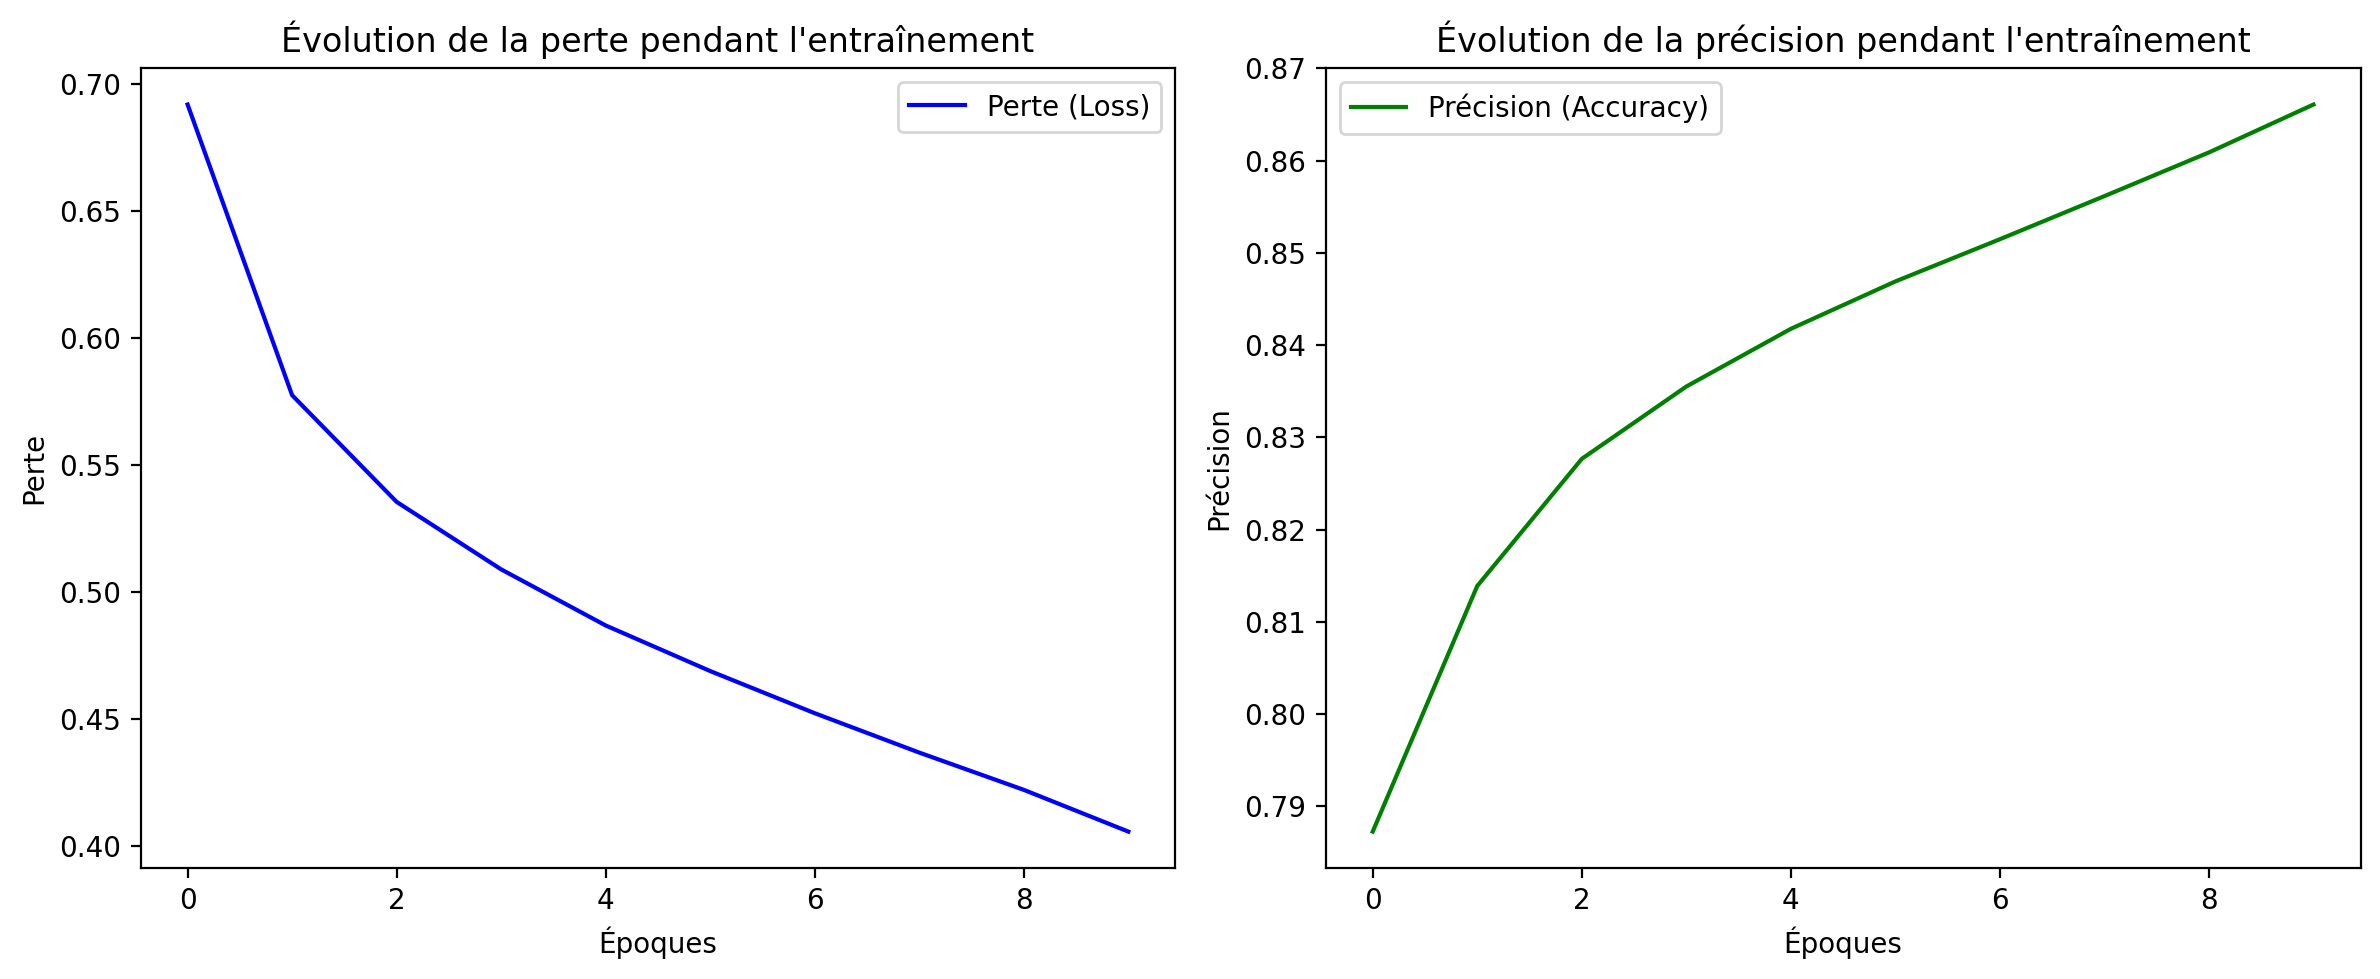

In [20]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Subplot 1 : Loss
axs[0].plot(history.history['loss'], label='Perte (Loss)', color='blue')
axs[0].set_xlabel('Époques')
axs[0].set_ylabel('Perte')
axs[0].set_title("Évolution de la perte pendant l'entraînement")
axs[0].legend()

# Subplot 2 : Accuracy
axs[1].plot(history.history['accuracy'], label='Précision (Accuracy)', color='green')
axs[1].set_xlabel('Époques')
axs[1].set_ylabel('Précision')
axs[1].set_title("Évolution de la précision pendant l'entraînement")
axs[1].legend()

# Affichage
plt.tight_layout()
plt.show()

In [14]:
# save the model
model.save(MODEL_PATH)

## Génération de mélodies

In [15]:
# load model
print(MODEL_PATH)
model = keras.models.load_model(MODEL_PATH)

# start symboles
start_symbols = ["/"] * SEQUENCE_LENGTH

# mappings
with open(MAPPING_PATH, "r") as fp:
    mappings = json.load(fp)

../data/deutsch/model_RNN_LSTM.keras


In [16]:
# Générer 10 mélodies
melodies = []
for _ in range (10):
    melodies.append(generate_melody(model, start_symbols, mappings, seed, 500, SEQUENCE_LENGTH, 0.7))


print(melodies[0])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━

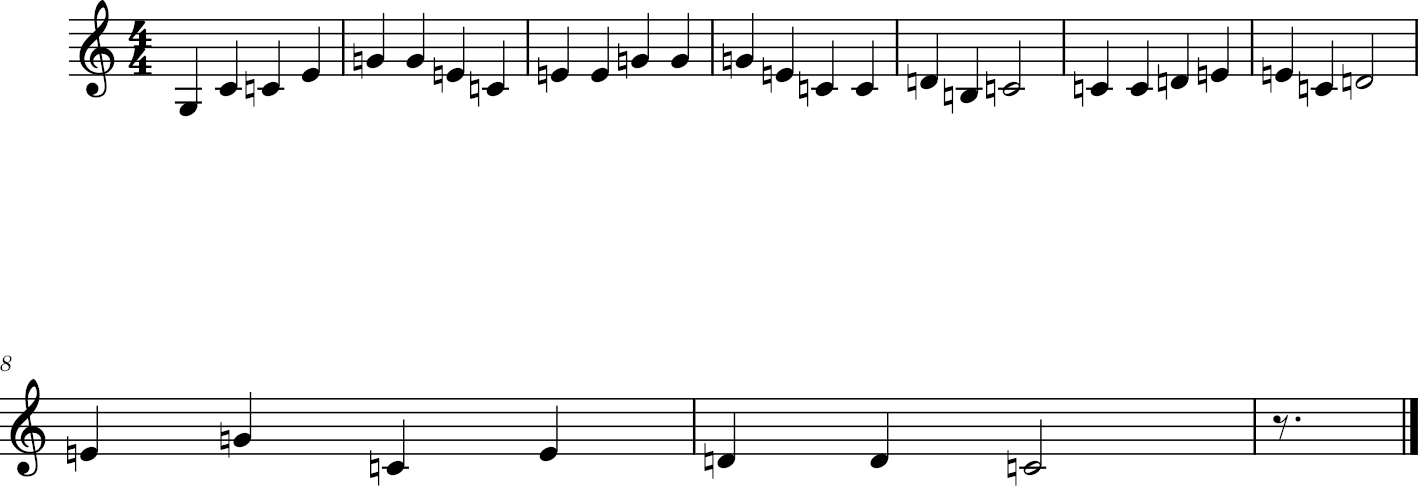

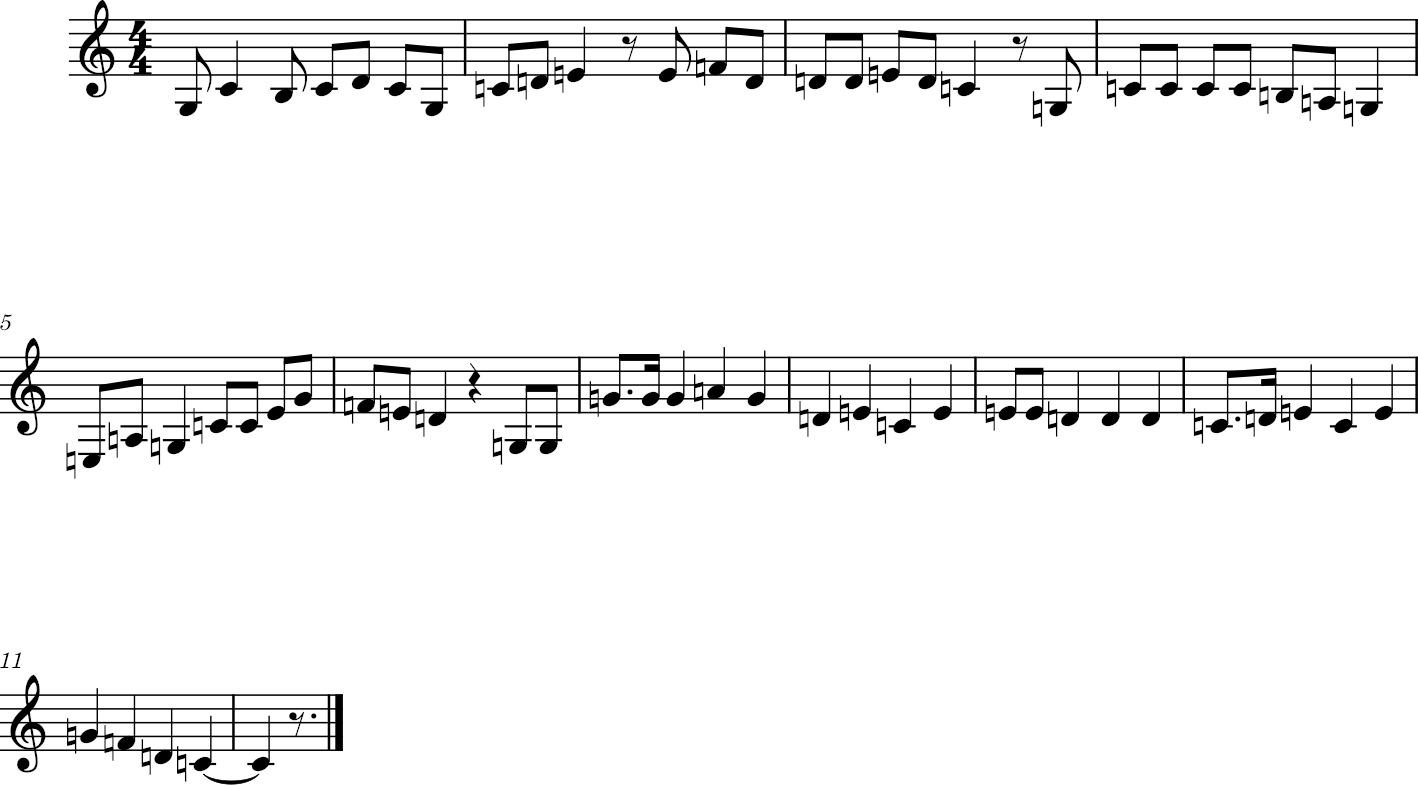

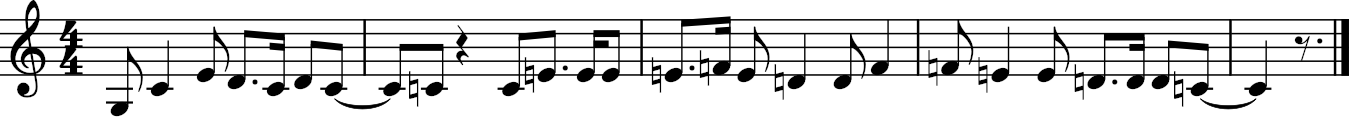

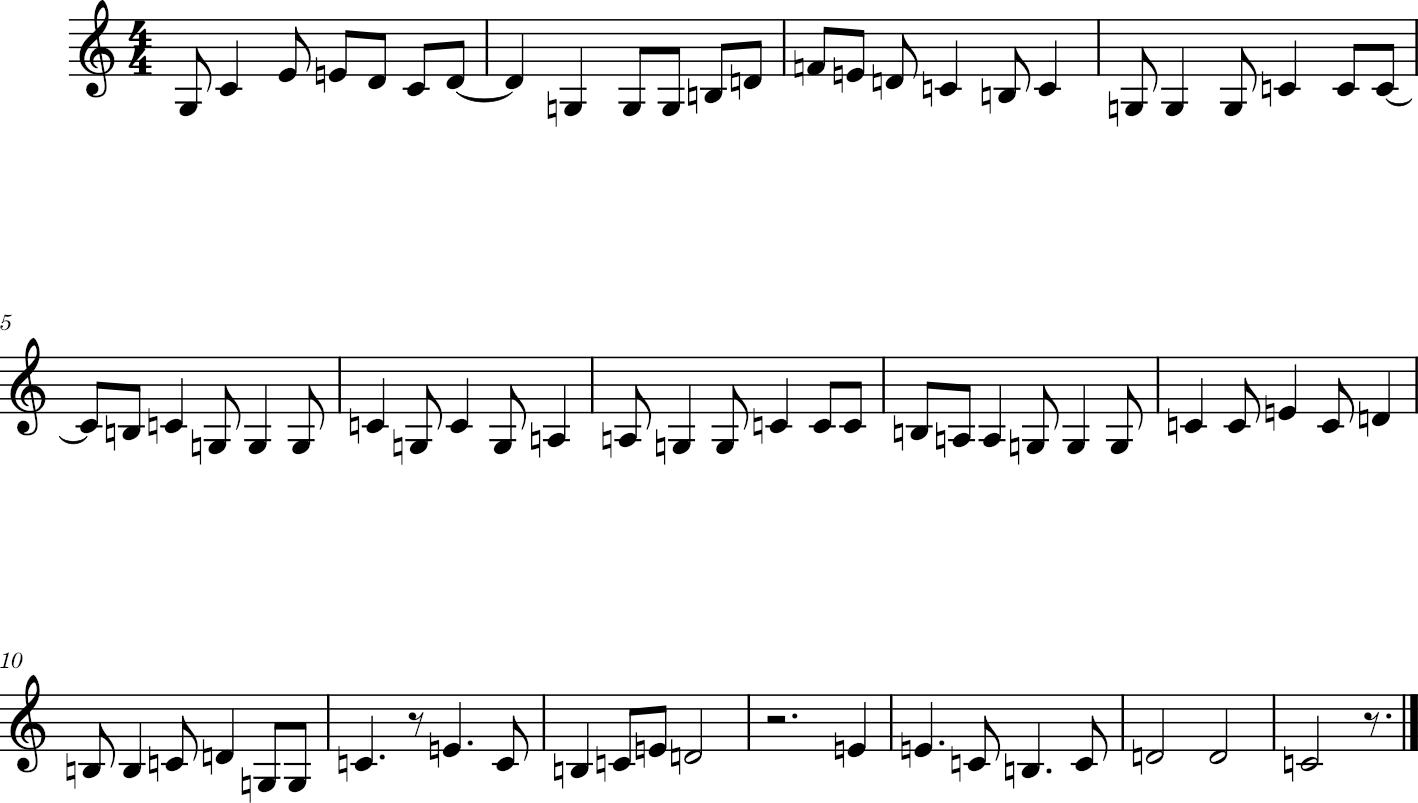

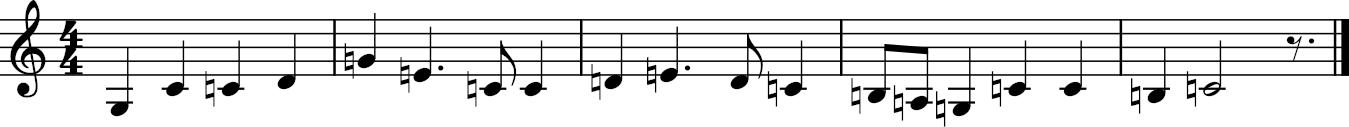

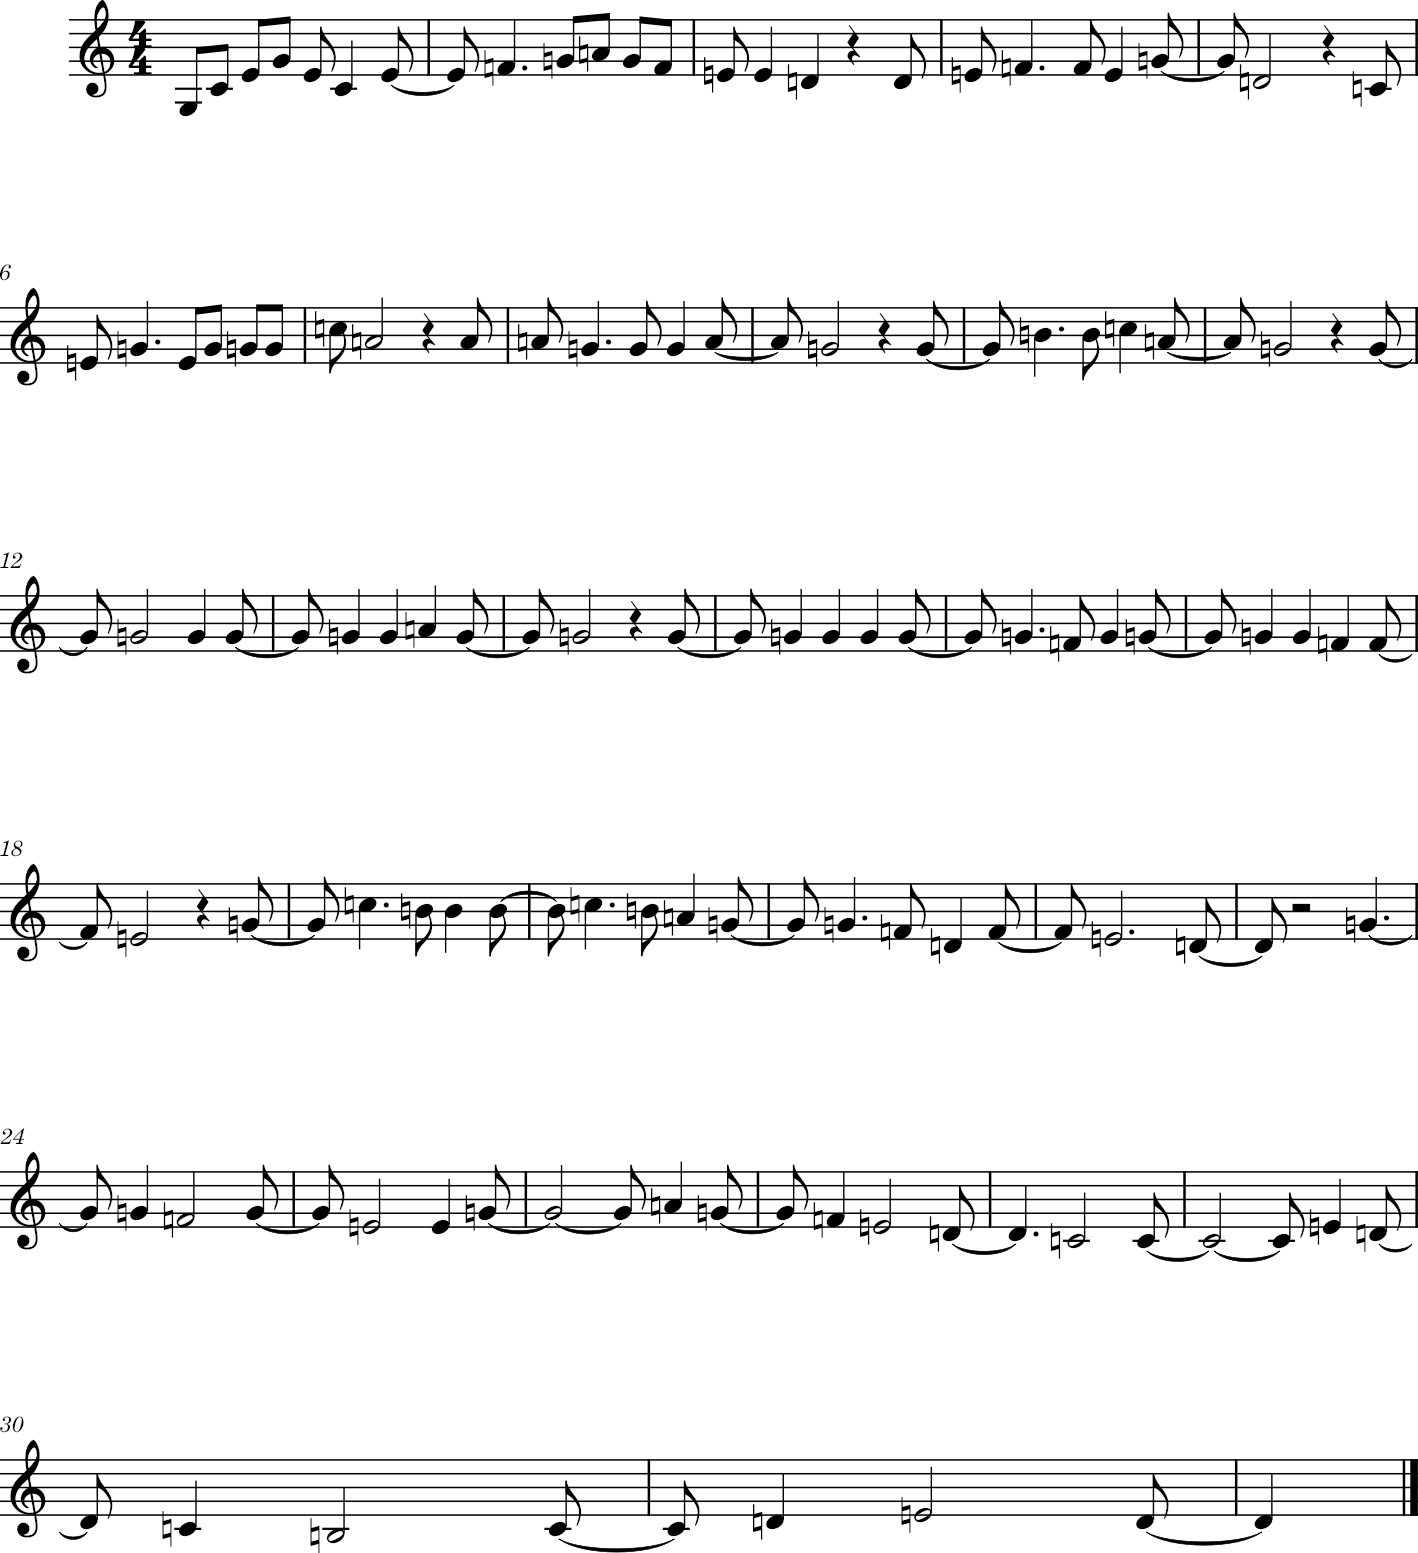

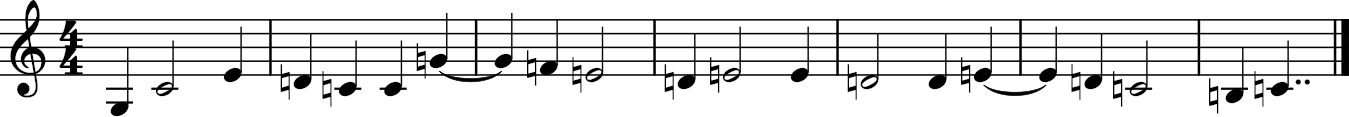

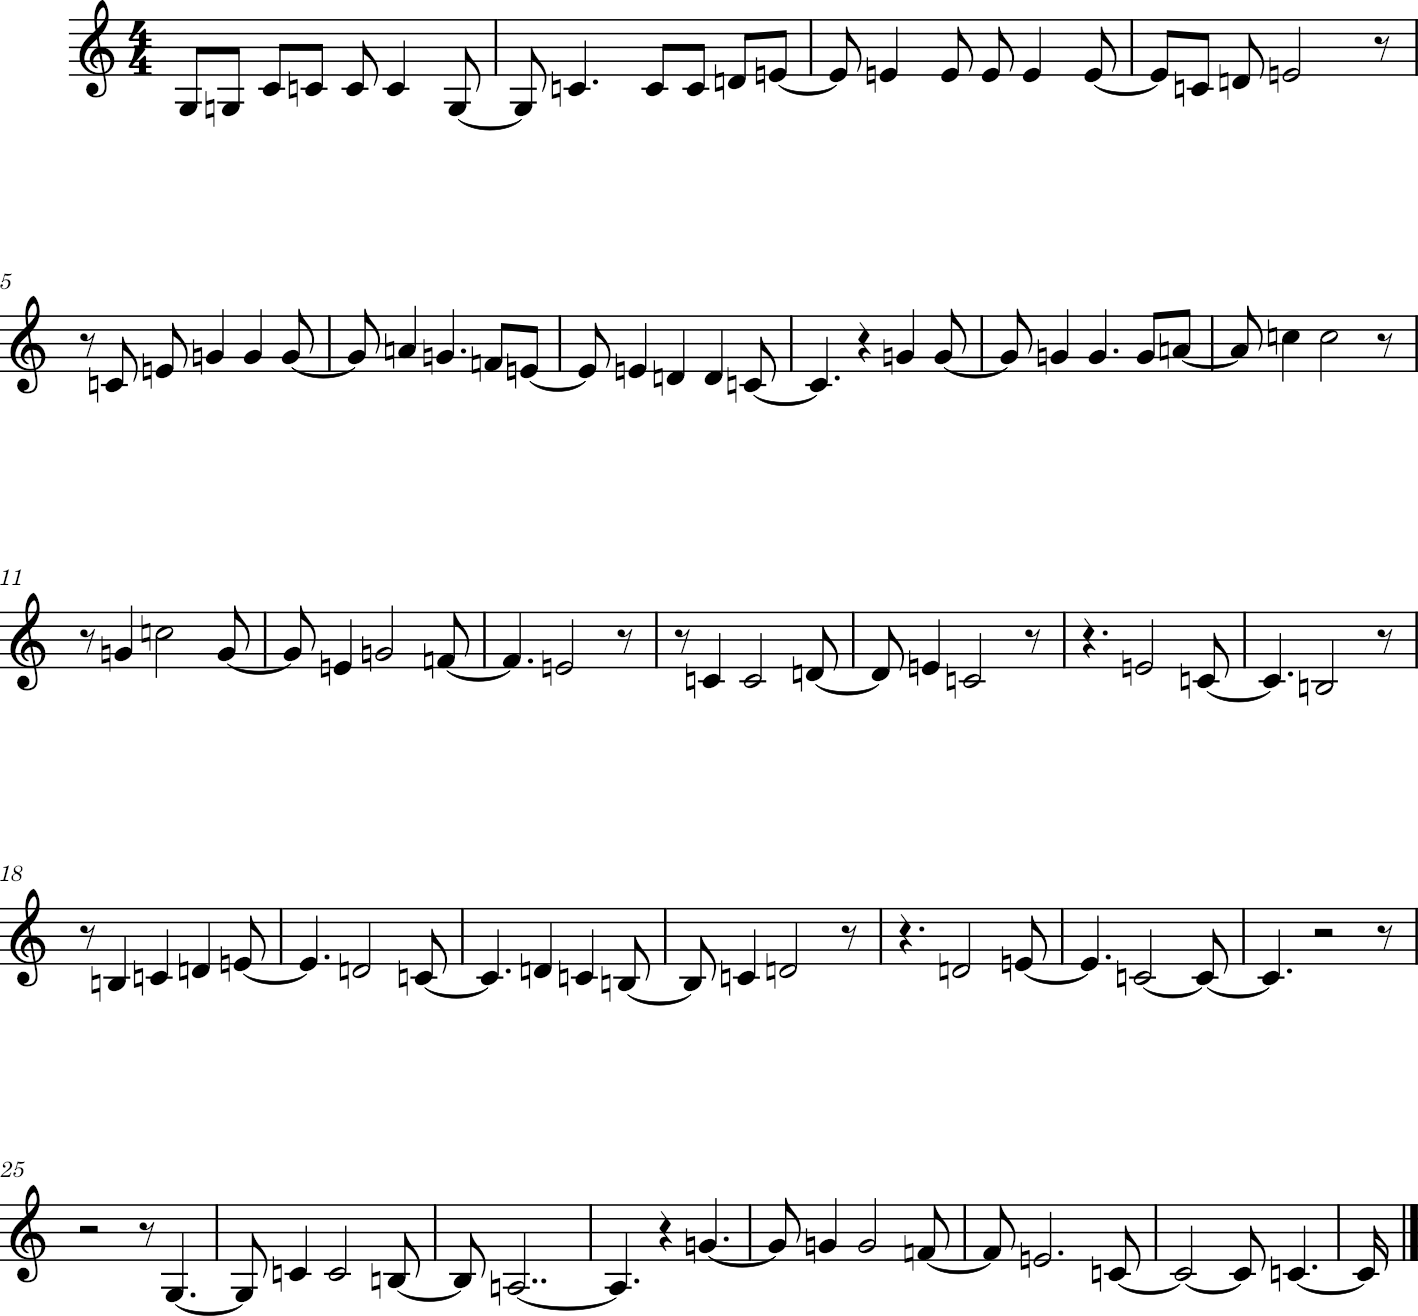

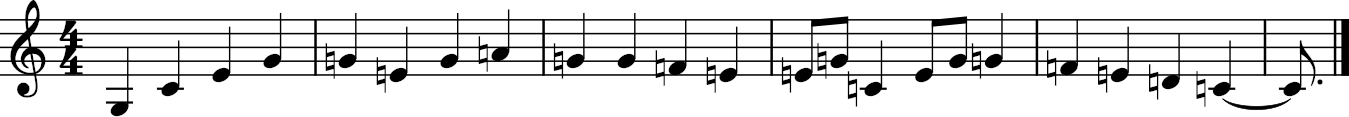

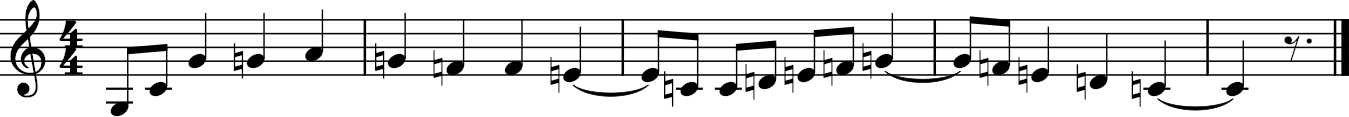

In [17]:
# Les mettre en format midi
songs = []
for i in range(10):
    songs.append(convert_to_midi(melodies[i]))

for song in songs:
    song.show("midi")
    song.show()

In [18]:
# save
timestamp = datetime.now().strftime("%d%m_%H%M%S")  # Format sauvegarde : JJMM_HHMMSS_i
for i in range(10):
    songs[i].write("midi", SAVE_GENERATED_MELODIES_DIR + f"/{timestamp}_{i}.mid")